In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import typing
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

In [4]:
data.columns

Index(['P1_p10', 'P1_p25', 'P1_p50', 'P1_p75', 'P1_p90', 'P1', 'P1_filtr_mean',
       'P2_p10', 'P2_p25', 'P2_p50', 'P2_p75', 'P2_p90', 'P2', 'P2_filtr_mean',
       'temperature_p10', 'temperature_p25', 'temperature_p50',
       'temperature_p75', 'temperature_p90', 'temperature',
       'temperature_filtr_mean', 'humidity_p10', 'humidity_p25',
       'humidity_p50', 'humidity_p75', 'humidity_p90', 'humidity',
       'humidity_filtr_mean', 'pressure_p10', 'pressure_p25', 'pressure_p50',
       'pressure_p75', 'pressure_p90', 'pressure', 'pressure_filtr_mean',
       'temp_meteo', 'pres_meteo', 'hum_meteo', 'wind_direction', 'wind_speed',
       'precipitation', 'prec_amount', 'prec_time', 'visibility',
       'dew_point_temp'],
      dtype='object')

# Распределения признаков в датасете
## PM2.5

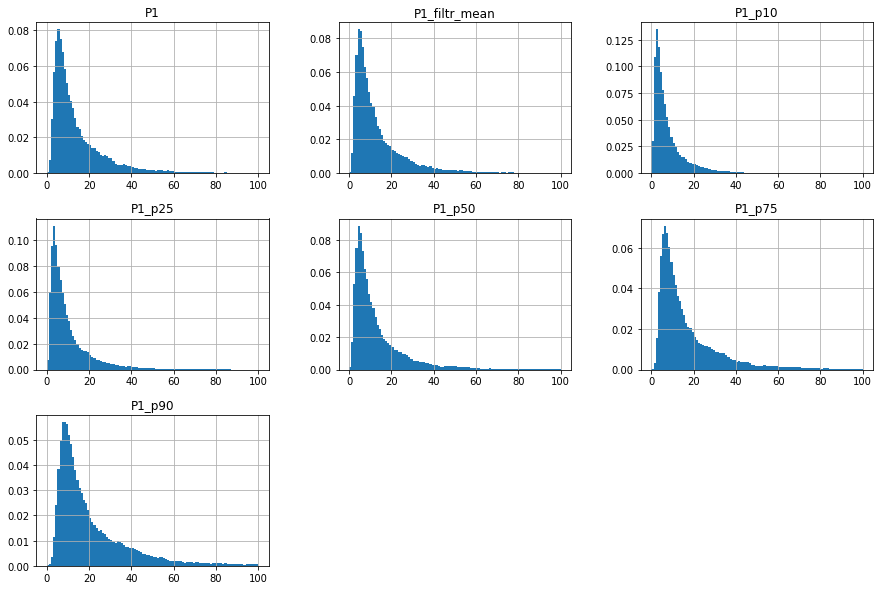

In [5]:
columns = ['P1', 'P1_filtr_mean', 'P1_p10', 'P1_p25', 'P1_p50', 'P1_p75', 'P1_p90']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10), range=(0,100))

P1_filtr_mean и p50 имеют похожее распределение, а P1 (среденне значение) имеет более тяжелый "хвост" из-за большего влияния выбросов.
## PM10

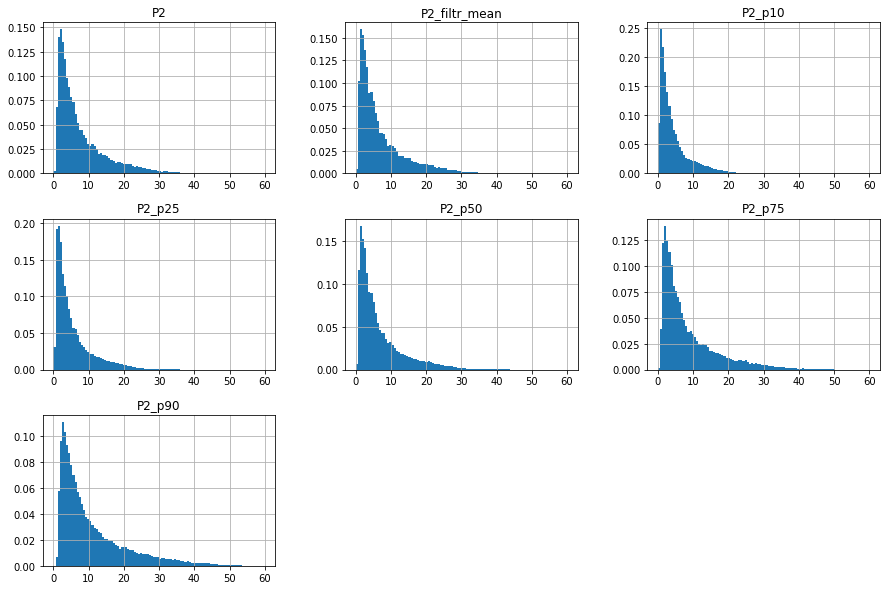

In [6]:
columns = ['P2', 'P2_filtr_mean', 'P2_p10', 'P2_p25', 'P2_p50', 'P2_p75', 'P2_p90']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10), range=(0,60))

Тут ситуация в целом аналогична PM2.5, но "хвосты" всех распределений ниже
## Humidity

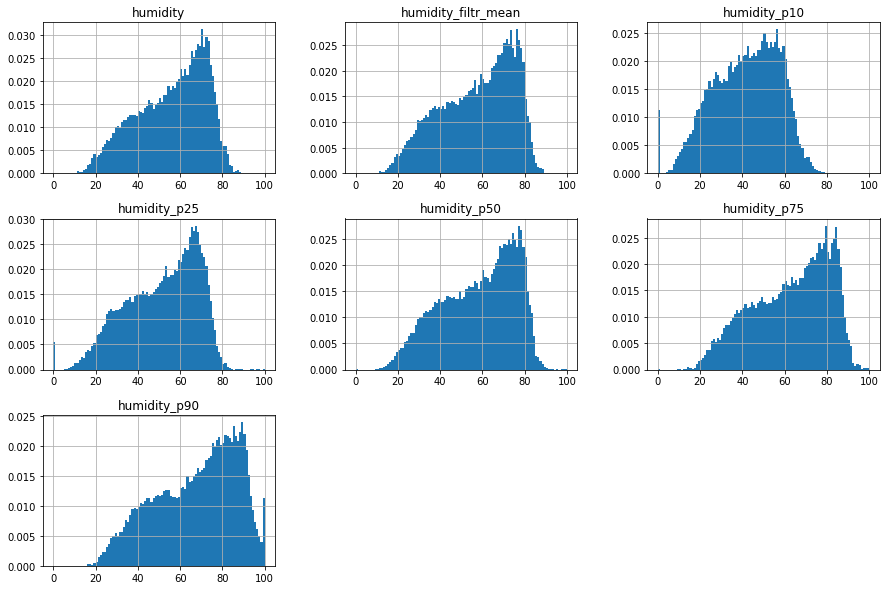

In [7]:
columns = ['humidity', 'humidity_filtr_mean', 'humidity_p10', 'humidity_p25',
       'humidity_p50', 'humidity_p75', 'humidity_p90']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10), range=(0,100))

## Temperature

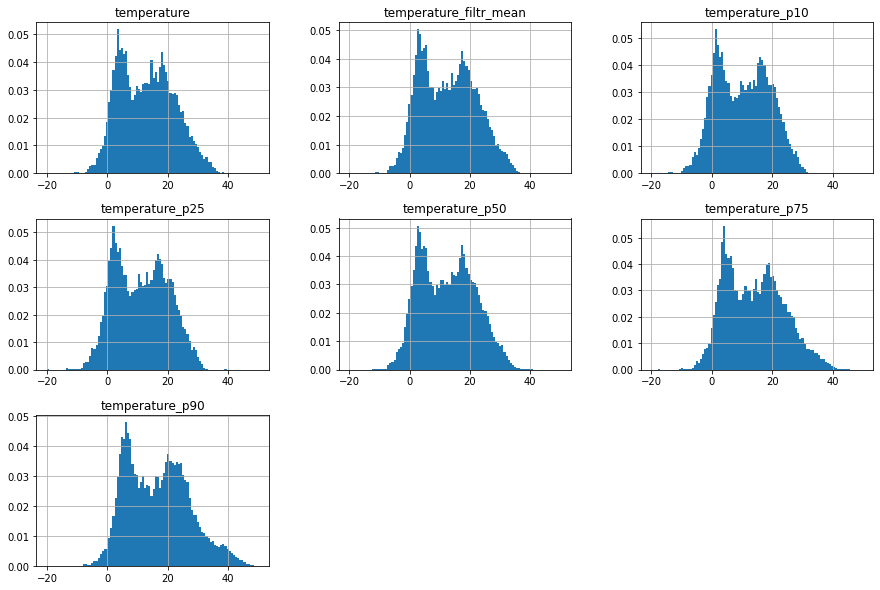

In [8]:
columns = [ 'temperature','temperature_filtr_mean','temperature_p10', 'temperature_p25', 'temperature_p50',
       'temperature_p75', 'temperature_p90']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10), range=(-20,50))

Все распределения имеют примерно одинаковый "хвост" со стороны низких температур, но temperature_filtr_mean и temperature_p50 имеют тяжелый "хвост" со стороны высоких температур чем обычное среднее - в сторону высоких температур больше выбросов.
## Pressure

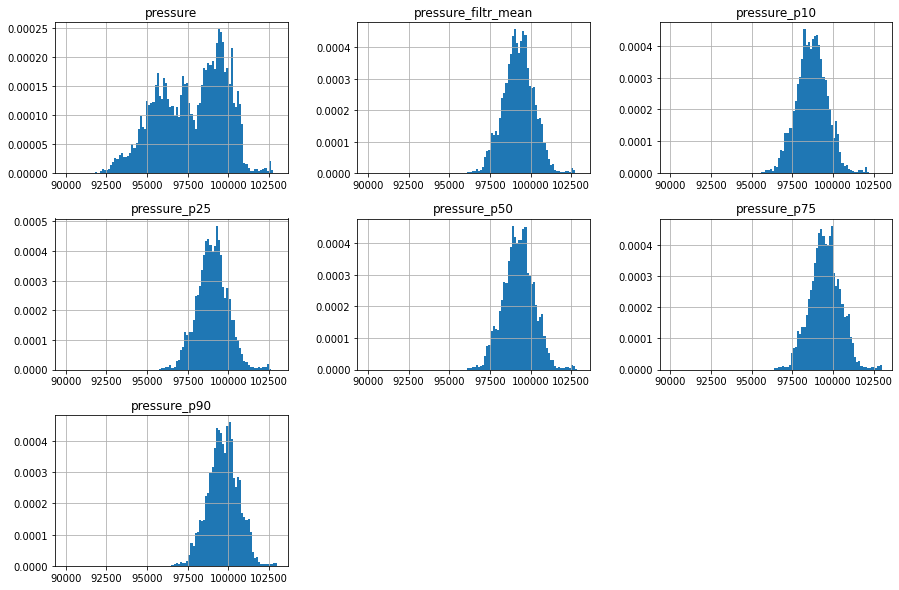

In [9]:
columns = ['pressure', 'pressure_filtr_mean',  'pressure_p10', 'pressure_p25', 'pressure_p50',
       'pressure_p75', 'pressure_p90']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10), range=(90000,103000))

Распределение среднего очень широкое, а центры распределений квантилей сильно смещены относительно
друг друга. Данные шумные, скорее всего из-за влияния высоты расположения датчика на показания.
## Meteo

In [10]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }

data['pres_meteo'] = data.pres_meteo.fillna(method='bfill')
data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
data['hum_meteo'] = data.hum_meteo.fillna(method='bfill') 
data['prec_amount'] = data.prec_amount.fillna(method='bfill')
data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
data['prec_amount'] = data.prec_amount.astype(float)
data['wind_direction'] = data.wind_direction.map(wind_dir)
data['wind_direction'] = data.wind_direction.fillna(method='bfill')


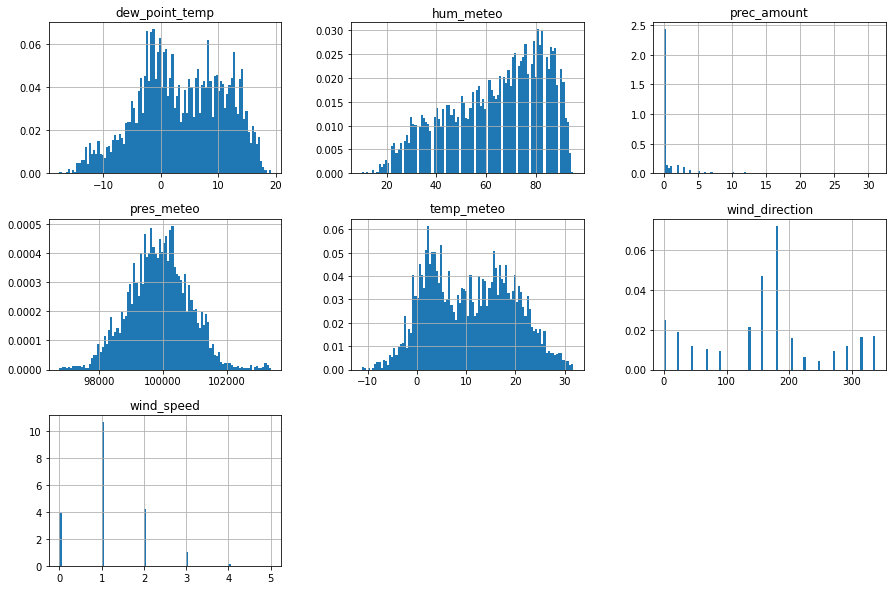

In [11]:
columns = ['temp_meteo', 'pres_meteo', 'hum_meteo', 'wind_direction',
           'wind_speed', 'prec_amount', 'dew_point_temp']
_ = data.hist(column=columns, density=True, bins=100, figsize=(15, 10))

# Влияние влажности на PM2.5 и PM10

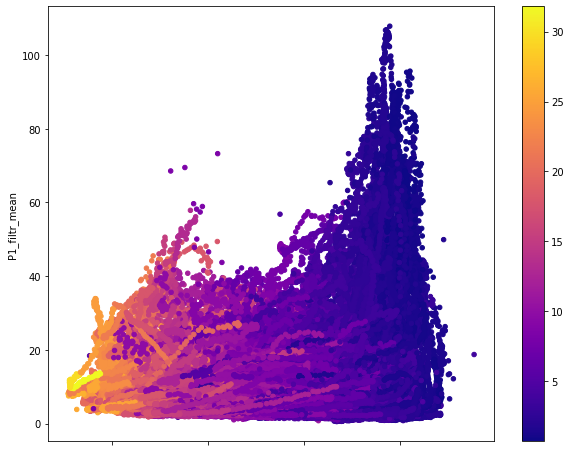

In [12]:
_ = data.plot.scatter( 'humidity_filtr_mean', 'P1_filtr_mean',
                  c=data.temp_meteo-data.dew_point_temp, colormap='plasma')

Цветом показана разница между текучей температурой и температурой точки росы. Видим, что при высокой влажности имеют место высокие значения концентрации частиц - датчик реагирует на капельки воды в воздухе. Тем не менее, высокое значение влажности не всегда означает высокие значения PM2.5

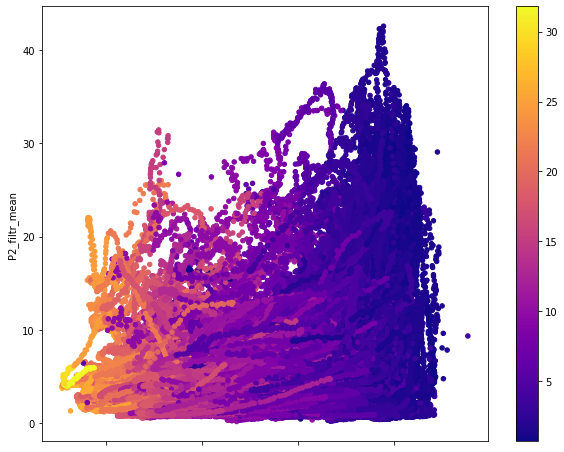

In [13]:
_ = data.plot.scatter( 'humidity_filtr_mean', 'P2_filtr_mean',
                  c=data.temp_meteo-data.dew_point_temp, colormap='plasma')

На PM10 влажность влияет в меньшей степени - по-видимому, капельки воды обычно меньше 10 мкм.
# Измение признаков во времени
В датасете время в UTC, приведем его к московскому

In [14]:
data = data.tz_convert('Europe/Moscow')

In [15]:
data['hour'] = data.index.hour
data['month'] = data.index.month

## Измение PM2.5 и PM10 в течении суток

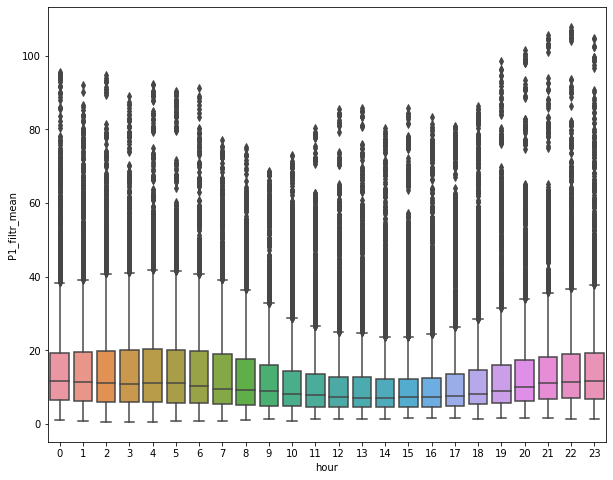

In [16]:
_ = sns.boxplot(x='hour', y='P1_filtr_mean', data=data)

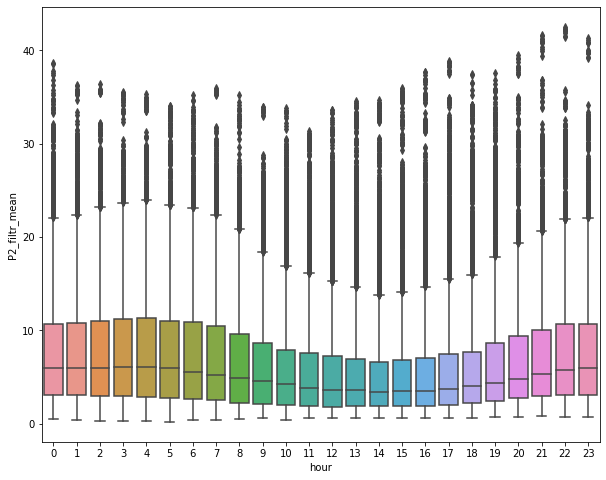

In [17]:
_ = sns.boxplot(x='hour', y='P2_filtr_mean', data=data)

Днем концентрация частиц уменьшается, что связано с улучшением условий рассеивания из-за активизации движения воздушных масс за счет конвекции
## Измение PM2.5 и PM10 в течении года

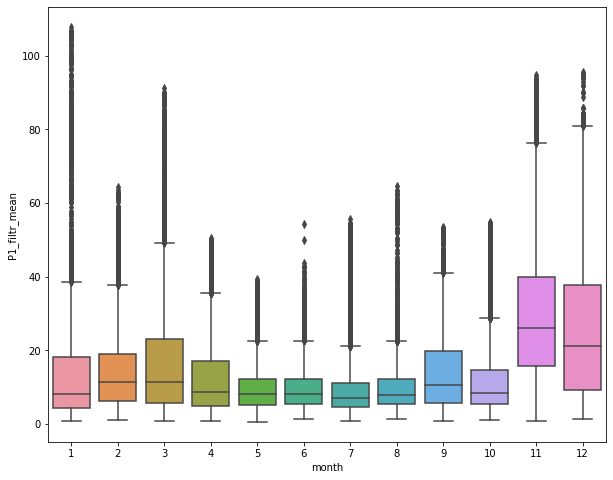

In [18]:
sns.boxplot(x='month', y='P1_filtr_mean', data=data)

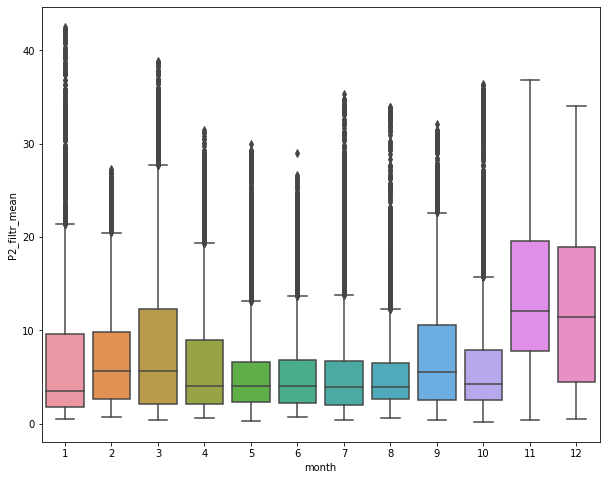

In [19]:
_ = sns.boxplot(x='month', y='P2_filtr_mean', data=data)

Летом в целом уровень концентрации частиц ниже чем зимой. При этом в ноябре и декабре центр масс распределения смещен в сторону более высоких значений, в феврале и январе центр масс ближе к летнему, но распределение имеет "хвост" в сторону высоких значений:

Text(0.5, 1.0, 'Июнь')

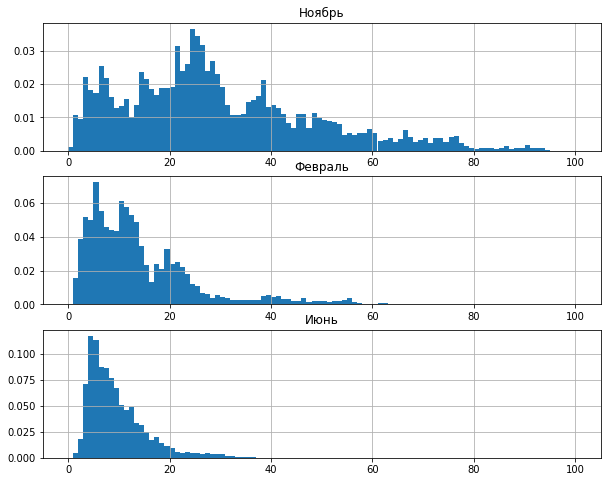

In [20]:
_ ,ax = plt.subplots(3, 1)
data[data.month==11].P1_filtr_mean.hist(ax=ax[0], bins=100, density=True, range=(0,100))
ax[0].set_title('Ноябрь')
data[data.month==2].P1_filtr_mean.hist(ax=ax[1], bins=100, density=True, range=(0,100))
ax[1].set_title('Февраль')
data[data.month==6].P1_filtr_mean.hist(ax=ax[2], bins=100, density=True, range=(0,100))
ax[2].set_title('Июнь')

Посмотрим что происходит с влажностью, скоростью ветра и насколько температура близка к точке росы

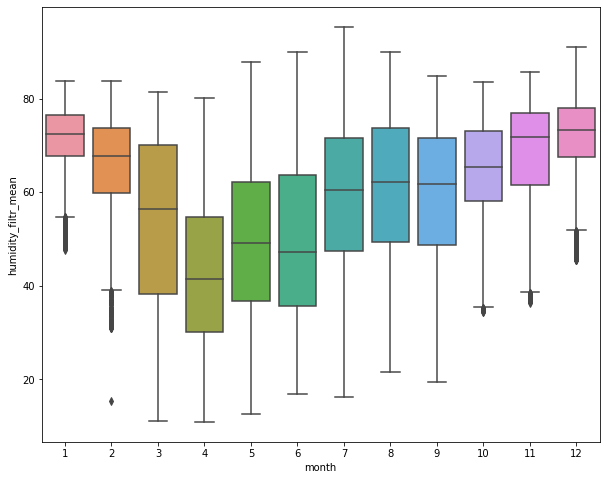

In [21]:
_ = sns.boxplot(x='month', y='humidity_filtr_mean', data=data)

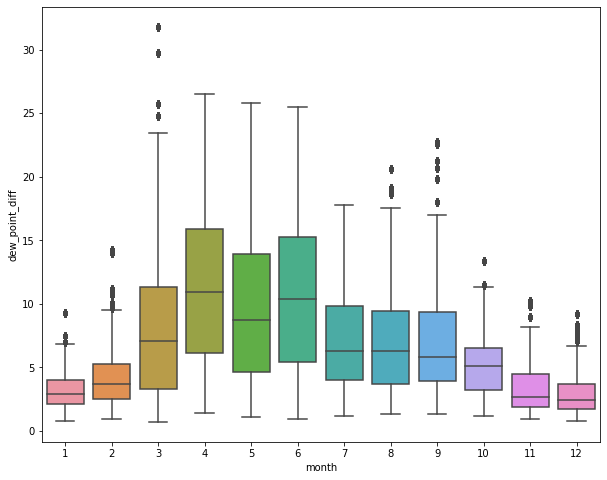

In [22]:
data['dew_point_diff'] = data.temp_meteo - data.dew_point_temp
_ = sns.boxplot(x='month', y='dew_point_diff', data=data)

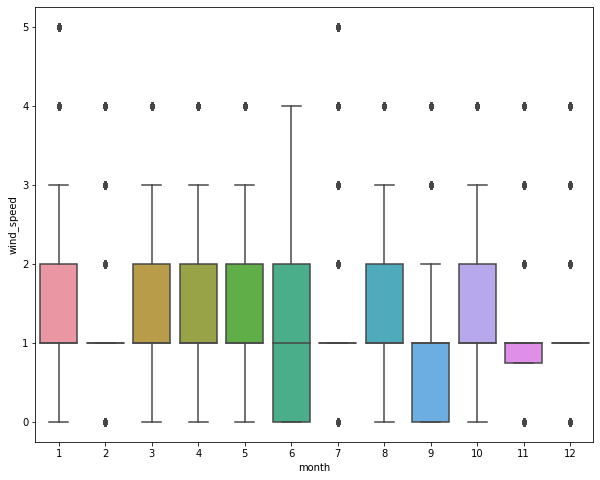

In [23]:
sns.boxplot(x='month', y='wind_speed', data=data)

Видим, что зимой высокая влажность и температура близка к точке росы, поэтому здесь много выбросов
в сторону высоких значений и у распределения появляется "хвост". Но в ноябре и декабре еще и ниже скорость ветра, поэтому воздух хуже перемещивается и смещается центр масс распределения в сторону более высоких значений.

# Anomalies

In [24]:
anomalies = pd.read_csv('../DATA/processed/anomalies.csv', parse_dates=['start_date', 'end_date'])

## Распределение признаков по кластерам
![distribution](../src/web/client/application/static/images/clusters_distribution.png)
см. [код](../src/model/extract_anomalies.py)

К кластеру 0 относятся аномалии, характеризующиеся снижением концентрации частиц из-за улучшения условий рассеяния (повышние скорости ветра). В кластере 2 увеличение PM2.5 связано с повышением влажности воздуха. В кластере 1 повышение концентрации частиц не связано с увеличением влажности.

## Общее число аномалий в кластерах и распределение их во времени

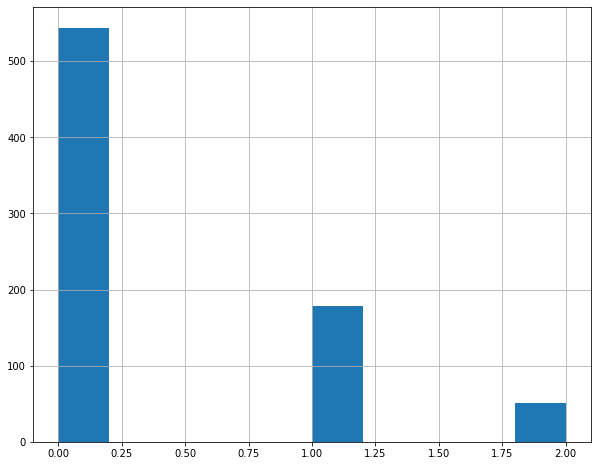

In [25]:
anomalies.cluster.hist()

In [26]:
df = anomalies.set_index('start_date')
df['cluster_0'] = (df.cluster == 0).astype(int)
df['cluster_1'] = (df.cluster == 1).astype(int)
df['cluster_2'] = (df.cluster == 2).astype(int)

In [27]:
df= df.groupby(pd.Grouper(freq='M')).sum()

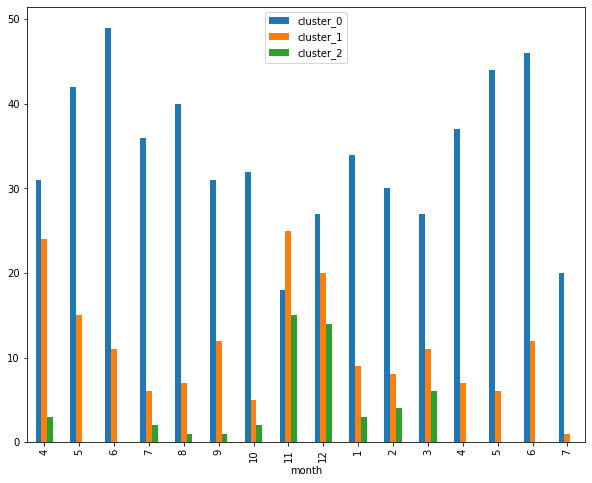

In [28]:
df['month'] = df.index.month 
df.plot.bar(x='month', y=['cluster_0', 'cluster_1', 'cluster_2'])